In [2]:
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import random

%load_ext autoreload

In [3]:
%autoreload 2
from classes.fpst import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")

dir = os.path.join(data_dir, "SPST_perfect")

In [6]:
num_maps = (512 * 512)

In [7]:
file = loadmat(os.path.join(dir, "FPSTdata_2_pol-60.mat"))

fpsts_26 = file["fpsts"][:num_maps]
forbiden = file["forbiden"][0]
coords_26 = file["coords"][:num_maps]

fpsts_26 = fpsts_26
coords_26 = coords_26

In [8]:
from PIL import Image

fpsts_32 = np.empty((len(fpsts_26), 32, 32))
for i in range(len(fpsts_26)):
    # Interpolate the map to 32x32 using the nearest neighbour method
    fpsts_32[i] = np.array(Image.fromarray(fpsts_26[i]).resize((32, 32), resample=Image.NEAREST))

# free memory
del fpsts_26

In [9]:
dir_path = os.path.join(data_dir, "interpol_64", "FPST_3MI2_-60")
total_tasks = num_maps

fpsts_64, coords_64 = load_FPST(dir_path, total_tasks)

Overhead done, starting the loop


Process: 100%|██████████| 262144/262144 [07:42<00:00, 566.44task/s]


In [10]:
fpsts_32 = np.array(list(map(process, fpsts_32)))
fpsts_64 = np.array(list(map(process, fpsts_64)))

max_32 = np.max(fpsts_32)
min_32 = np.min(fpsts_32)
fpsts_32 = (fpsts_32 - min_32) / (max_32 - min_32)

max_64 = np.max(fpsts_64)
min_64 = np.min(fpsts_64)
fpsts_64 = (fpsts_64 - min_64) / (max_64 - min_64)

109772


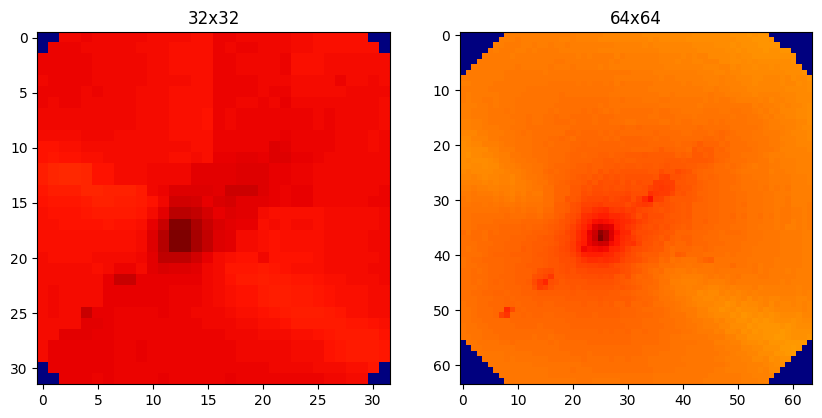

In [11]:
ind = random.randint(0, len(fpsts_64))
print(ind)

fpst_32 = fpsts_32[ind]
fpst_64 = fpsts_64[ind]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fpst_32, cmap="jet")
axs[0].set_title("32x32")
axs[1].imshow(fpst_64, cmap="jet")
axs[1].set_title("64x64")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fpsts_32[:total_tasks], fpsts_64, test_size=0.2, random_state=42)

In [13]:
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [14]:
from classes.better_models_fpst import get_espcn, get_discriminator
from classes.better_models_fpst import conv_block
from classes.better_models_fpst import train, train_gan, train_and_evaluate_model
import tensorflow as tf
import tensorflow.keras as keras

In [15]:
# upsample X_train and X_test to 64x64 with bicubic interpolation
''' X_train_up = np.empty((len(X_train), 64, 64))
X_test_up = np.empty((len(X_test), 64, 64))

for i in range(len(X_train)):
    X_train_up[i] = np.array(Image.fromarray(X_train[i].squeeze()).resize((64, 64), resample=Image.BICUBIC))
for i in range(len(X_test)):
    X_test_up[i] = np.array(Image.fromarray(X_test[i].squeeze()).resize((64, 64), resample=Image.BICUBIC))

X_train_up = np.expand_dims(X_train_up, axis=-1)
X_test_up = np.expand_dims(X_test_up, axis=-1) '''

' X_train_up = np.empty((len(X_train), 64, 64))\nX_test_up = np.empty((len(X_test), 64, 64))\n\nfor i in range(len(X_train)):\n    X_train_up[i] = np.array(Image.fromarray(X_train[i].squeeze()).resize((64, 64), resample=Image.BICUBIC))\nfor i in range(len(X_test)):\n    X_test_up[i] = np.array(Image.fromarray(X_test[i].squeeze()).resize((64, 64), resample=Image.BICUBIC))\n\nX_train_up = np.expand_dims(X_train_up, axis=-1)\nX_test_up = np.expand_dims(X_test_up, axis=-1) '

In [16]:
''' model = get_espcn((32, 32), 2, 3, 64, 32, learning_rate=1e-3, conv_block=conv_block_bn_leaky)
model_dir = os.path.join(root_dir, "models")
history = train(model, X_train, y_train, X_test, y_test, batch_size=1, epochs=10, model_name='espcn', save_dir=model_dir, save_weights_only=False) '''

' model = get_espcn((32, 32), 2, 3, 64, 32, learning_rate=1e-3, conv_block=conv_block_bn_leaky)\nmodel_dir = os.path.join(root_dir, "models")\nhistory = train(model, X_train, y_train, X_test, y_test, batch_size=1, epochs=10, model_name=\'espcn\', save_dir=model_dir, save_weights_only=False) '

In [17]:
''' input_shape = (32, 32, 1)  # Input shape for the 32x32 images (grayscale)
upscale_factor = 2         # Upscale factor from 32x32 to 64x64 images
output_shape = (upscale_factor * input_shape[0], upscale_factor * input_shape[1], 1) # Input shape for the 64x64 images (grayscale)
num_layers = 5             # Number of layers for the generator (you can adjust this as needed)
num_filters_1 = 64         # Number of filters for the first layer of the generator
num_filters_2 = 32         # Number of filters for the subsequent layers of the generator

# Create the generator model
generator = get_espcn(input_shape, upscale_factor, num_layers, num_filters_1, num_filters_2, conv_block_bn)

# Create the discriminator model
discriminator = get_discriminator(output_shape)

# Training parameters
batch_size = 64
epochs = 100
learning_rate = 1e-4  # You can experiment with different learning rates

# Train the GAN
history = train_gan(generator, discriminator, X_train, y_train, X_test, y_test, batch_size, epochs, learning_rate) '''

' input_shape = (32, 32, 1)  # Input shape for the 32x32 images (grayscale)\nupscale_factor = 2         # Upscale factor from 32x32 to 64x64 images\noutput_shape = (upscale_factor * input_shape[0], upscale_factor * input_shape[1], 1) # Input shape for the 64x64 images (grayscale)\nnum_layers = 5             # Number of layers for the generator (you can adjust this as needed)\nnum_filters_1 = 64         # Number of filters for the first layer of the generator\nnum_filters_2 = 32         # Number of filters for the subsequent layers of the generator\n\n# Create the generator model\ngenerator = get_espcn(input_shape, upscale_factor, num_layers, num_filters_1, num_filters_2, conv_block_bn)\n\n# Create the discriminator model\ndiscriminator = get_discriminator(output_shape)\n\n# Training parameters\nbatch_size = 64\nepochs = 100\nlearning_rate = 1e-4  # You can experiment with different learning rates\n\n# Train the GAN\nhistory = train_gan(generator, discriminator, X_train, y_train, X_test

In [18]:
''' model_dir = os.path.join(root_dir, "models")
model_list = ['FPST_32_64_srcnn.h5', 'FPST_32_64_cnn.h5', 'FPST_32_64_cnn_mae.h5', 'FPST_32_64_better_sp.h5', 'FPST_32_64_espcn.h5', 'FPST_32_64_fsr.h5']
scores = []
for model_name in model_list:
  print(model_name)
  model = keras.models.load_model(os.path.join(model_dir, model_name))
  score = model.evaluate(X_test, y_test)
  scores.append(score)

for i in range(len(scores)):
  model_name = model_list[i]
  score = scores[i]
  print(f"{model_name} : {score}") '''

' model_dir = os.path.join(root_dir, "models")\nmodel_list = [\'FPST_32_64_srcnn.h5\', \'FPST_32_64_cnn.h5\', \'FPST_32_64_cnn_mae.h5\', \'FPST_32_64_better_sp.h5\', \'FPST_32_64_espcn.h5\', \'FPST_32_64_fsr.h5\']\nscores = []\nfor model_name in model_list:\n  print(model_name)\n  model = keras.models.load_model(os.path.join(model_dir, model_name))\n  score = model.evaluate(X_test, y_test)\n  scores.append(score)\n\nfor i in range(len(scores)):\n  model_name = model_list[i]\n  score = scores[i]\n  print(f"{model_name} : {score}") '

In [19]:
import gc
import tensorflow as tf

# Libérer la mémoire du GPU
def clear_gpu_memory():
    tf.keras.backend.clear_session()
    gc.collect()

# Appeler cette fonction chaque fois que vous voulez libérer la mémoire du GPU
clear_gpu_memory()

In [ ]:
# Define the hyperparameters and architectures for the grid search
batch_sizes = [16] # try lower batch sizes for the best models
epochs_list = [20]
architectures = [(9, 128, 64), (17, 128, 64), (33, 128, 64)]
activations = ['relu']
batch_norms = [True, False]
dropout_rates = [0.0, 0.2, 0.5]
inits = ['glorot_uniform', 'he_normal', 'lecun_normal']

tot = len(batch_sizes) * len(batch_norms) * len(architectures) * len(dropout_rates) * len(inits)

# Loop through the grid and perform the grid search
results = []
histories = []
ind = 1

# Set memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

for batch_size in batch_sizes:
    for epochs in epochs_list:
        for num_layers, num_filters_1, num_filters_2 in architectures:
            for activation in activations:
                for batch_norm in batch_norms:
                    for dropout_rate in dropout_rates:
                        for init in inits:
                            print(ind, '/', tot, ' : ')
                            loss, history = train_and_evaluate_model(X_train, y_train, X_test, y_test, batch_size,
                                                                    epochs, num_layers, num_filters_1, num_filters_2,
                                                                    activation, batch_norm, dropout_rate, init)
                            results.append({
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'num_layers': num_layers,
                                'num_filters_1': num_filters_1,
                                'num_filters_2': num_filters_2,
                                'activation' : activation,
                                'batch_norm' : batch_norm,
                                'dropout_rate' : dropout_rate,
                                'init' : init,
                                'loss': loss
                            })
                            histories.append(history)
                            clear_gpu_memory()
                            ind += 1

# Save the results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(root_dir, 'grid_search_results_2.csv'), index=False)

import pickle
# Save histories to a separate file (optional)
with open(os.path.join(root_dir, 'grid_search_histories_2.pkl'), 'wb') as f:
    pickle.dump(histories, f)

In [ ]:
import pickle
# Save histories to a separate file (optional)
with open(os.path.join(root_dir, 'grid_search_histories_2.pkl'), 'wb') as f:
    pickle.dump(histories, f)

In [ ]:
import pickle
import tensorflow as tf
from tensorflow import keras

# Load histories from the dumped file
with open(os.path.join(root_dir, 'grid_search_histories_2.pkl'), 'rb') as f:
    histories_2 = pickle.load(f)

In [ ]:
results_df = pd.read_csv(os.path.join(root_dir, 'grid_search_results_2.csv'))

In [ ]:
#results_df.index[results_df['learning_rate'] == 0.001]

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
            58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
           dtype='int64')

In [ ]:
#clean_results = results_df[results_df['learning_rate'] == 0.001]
clean_results = results_df.sort_values(by='loss', ascending=True)
clean_results = clean_results.drop(columns=['batch_size', 'epochs', 'activation'])

clean_results.head(10)

,num_layers,num_filters_1,num_filters_2,batch_norm,dropout_rate,init,loss
19,17,128,64,True,0.0,he_normal,0.000008
45,33,128,64,False,0.0,glorot_uniform,0.000008
47,33,128,64,False,0.0,lecun_normal,0.000009
27,17,128,64,False,0.0,glorot_uniform,0.000009
28,17,128,64,False,0.0,he_normal,0.000009
37,33,128,64,True,0.0,he_normal,0.000009
20,17,128,64,True,0.0,lecun_normal,0.000010
10,9,128,64,False,0.0,he_normal,0.000011
9,9,128,64,False,0.0,glorot_uniform,0.000011
29,17,128,64,False,0.0,lecun_normal,0.000011


7.0487535595020745e-06


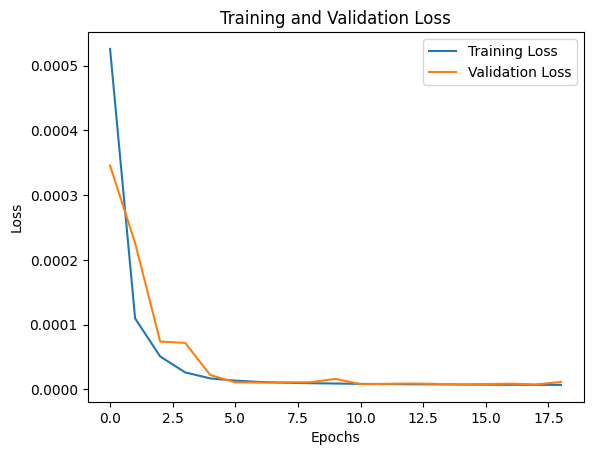

In [ ]:
import matplotlib.pyplot as plt

ind = 19
history = histories[ind]
print(np.min(history.history['loss']))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Define the hyperparameters and architectures for the grid search
batch_size = 1
epochs = 20
(num_layers, num_filters_1, num_filters_2) = (17, 128, 64)
activation = 'relu'
batch_norm = True
dropout = 0.0
init = 'he_normal'

input_shape = (X_train.shape[1], X_train.shape[2])
model = get_espcn(input_shape, 2, num_layers, num_filters_1, num_filters_2, activation, batch_norm, dropout, init)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = train(model, X_train, y_train, batch_size, epochs, verbose=True)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

Epoch 1/20
167772/167772 [==============================] - 2284s 14ms/step - loss: 8.0738e-05 - val_loss: 2.8924e-05
Epoch 2/20
150996/167772 [==========================>...] - ETA: 3:33 - loss: 9.7141e-06

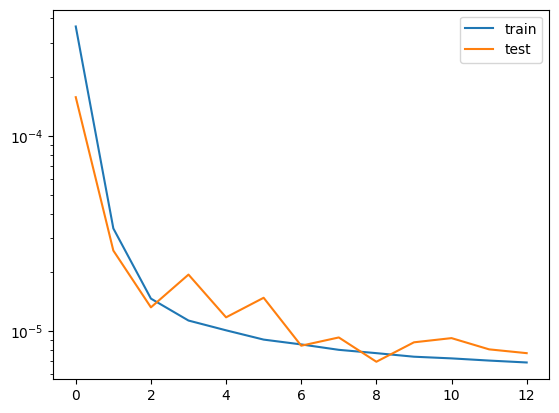

In [21]:
# Plot the history
history = history.history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.yscale('log')
plt.legend()
plt.show()

In [39]:
def get_corners(len_map, size):
    # the corners are triangles of size size

    corners = []
    for i in range(size):
        for j in range(size):
            if i + j < size:
                corners.append([i, j])
            else:
                break

    # replicate the corners to the other 3 quadrants
    corners = corners + [[len_map - i - 1, j] for i, j in corners]
    corners = corners + [[i, len_map - j - 1] for i, j in corners]
    corners = corners + [[len_map - i - 1, len_map - j - 1] for i, j in corners]

    return corners

def nullify_corners(map):
    len_map = map.shape[0]
    corners = []
    if len_map == 26:
        corners = get_corners(len_map, 2)
    elif len_map == 32:
        corners = get_corners(len_map, 2)
    elif len_map == 64:
        corners = get_corners(len_map, 8)
    elif len_map == 128:
        pass

    for i, j in corners:
        map[i, j] = 0

    return map

1/1 [==============================] - 0s 23ms/step


<ipython-input-59-dbfdd3540237>:20: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(input), cmap="jet")
<ipython-input-59-dbfdd3540237>:22: RuntimeWarning: divide by zero encountered in log10
  axs[1].imshow(np.log10(label), cmap="jet")
<ipython-input-59-dbfdd3540237>:24: RuntimeWarning: divide by zero encountered in log10
  axs[2].imshow(np.log10(pred), cmap="jet")


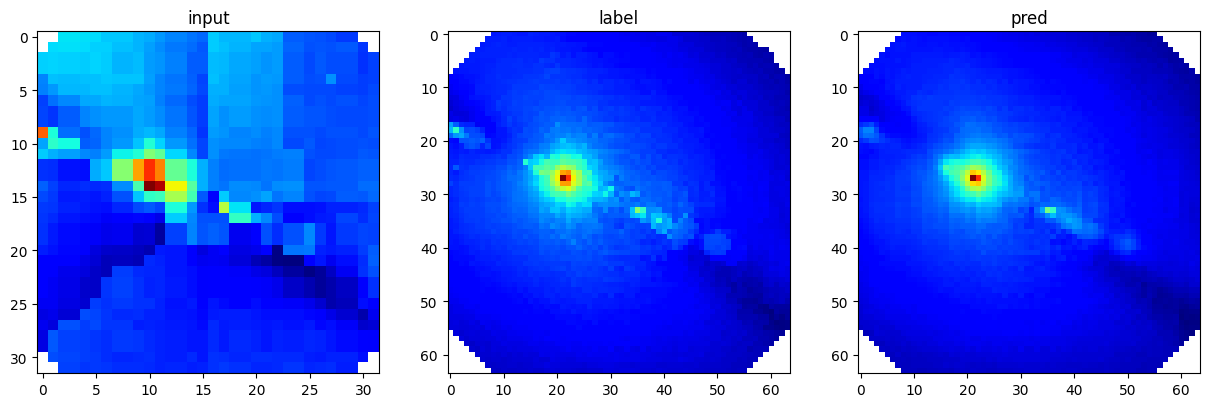

In [59]:
ind = random.randint(0, X_test.shape[0]-1)

input = X_test[ind]

label = y_test[ind]

pred = model.predict(X_test[ind:ind+1])[0,:,:,0]
pred = nullify_corners(pred)

pred = pred * (max_64 - min_64) + min_64
label = label * (max_64 - min_64) + min_64

pred = rev_process(pred)
label = rev_process(label)

pred = np.array(list(pred))
label = np.array(list(label))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(np.log10(input), cmap="jet")
axs[0].set_title("input")
axs[1].imshow(np.log10(label), cmap="jet")
axs[1].set_title("label")
axs[2].imshow(np.log10(pred), cmap="jet")
axs[2].set_title("pred")
plt.show()

In [ ]:
# predict the FPST of the entire dataset

# load the model
model_dir = os.path.join(root_dir, "models")
model = keras.models.load_model(os.path.join(model_dir, "FPST_32_64_sub_pixel_goat_1.h5"))

len_map = 32
upscale = 2
len_map_big = len_map * upscale

batch_size = 32

X = fpsts_32

X = np.expand_dims(X, axis=-1)

# predict
y_preds = model.predict(X, batch_size=batch_size)
# reshape
y_preds = y_preds.reshape(-1, len_map_big, len_map_big)

# nullify the corners (apply the nullify_corners function to each map)
y_preds = np.array([nullify_corners(y_pred) for y_pred in y_preds])

# save the predictions
np.save(os.path.join(root_dir, "data", "FPST_32_64_sub_pixel_goat_1_preds.npy"), y_preds)

y_preds = np.load(os.path.join(root_dir, "data", "FPST_32_64_sub_pixel_goat_1_preds.npy"))

In [22]:
# Save the model

model_dir = os.path.join(root_dir, "models")
model.save(os.path.join(model_dir, "FPST_32_64_sub_pixel_goat_1.h5"))